In [1]:
import sys
sys.path.append("../")

from Config import *
from Utilities import *
from Solver import *
from Jam_generator import *
from Functions import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Jamiton

In [2]:
# Elección valores sónicos
rho_min_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.1*rho_max, method="lm").x[0]
rho_max_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.7*rho_max, method="lm").x[0]

tau = 5
rho_s = 0.43334728629845265 * rho_max #0.43334728629845265 * rho_max #0.385 * rho_max # 0.64
v_s = 1/rho_s # Se necesita rho_s normalizado

m_bar = -h_bar_prime(v_s)
s_bar = U_bar(v_s) - m_bar * v_s

In [3]:
v_M  = newton_1D(50, lambda v: w_v(v, m_bar, s_bar), lambda v: w_v_prime(v, m_bar, s_bar))
r_min = r(v_s, m_bar)
r_max = r(v_M, m_bar)

v_R = root(lambda v: r(v, m_bar) - r_max, 10).x[0]

# Jamiton actual
v_minus = (v_M + v_s)/2
r_minus = r(v_minus, m_bar)
v_plus = newton_1D(8, lambda v: r(v, m_bar) - r_minus, lambda v: r_prime(v, m_bar))
r_plus = r(v_plus, m_bar)

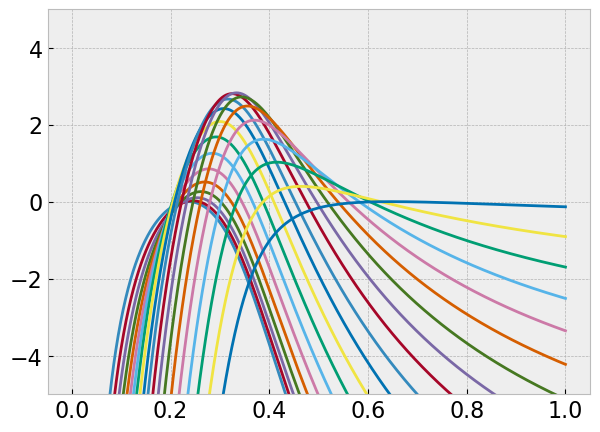

In [4]:
rhos_s = np.linspace(rho_min_scc, rho_max_scc, 20)
vs_s = 1/rhos_s

ms_bar = -h_bar_prime(vs_s)
ss_bar = U_bar(vs_s) - ms_bar * vs_s

v_to_plot = np.linspace(1, 55, 1000)
rho_to_plot = np.linspace(0, 1, 1000)[1:]*rho_max
v_to_plot = 1/rho_to_plot
for j in range(len(rhos_s)):
    
    plt.plot(rho_to_plot/rho_max, w_v(v_to_plot, ms_bar[j], ss_bar[j]), label=r"$\rho$={}".format(round(rhos_s[j]/rho_max, 3)))

#plt.legend(fontsize=10)
#plt.hlines(0, 8, 60, ls="--")
plt.ylim(-5, 5)
plt.show()

In [5]:
# Resuelve EDO
t_f = 800
N_ODE = int(1e7)
sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[tau, m_bar, s_bar], dense_output=True)
sol_v_eta = solve_ivp(ode_jam_v_eta, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[m_bar, s_bar], dense_output=True)

sol_rho = lambda x: 1/sol_v.sol(x)[0]
sol_u = lambda x: rho_to_u(sol_rho(x), m_bar, s_bar)

sol_rho_eta = lambda x: 1/sol_v_eta.sol(x)[0]
sol_u_eta = lambda x: rho_to_u(sol_rho_eta(x), m_bar, s_bar)

# Encuentra xs
x_minus = newton(lambda v: sol_v.sol(v)[0] - v_minus, v_minus)
x_plus = newton(lambda v: sol_v.sol(v)[0] - v_plus, 0)

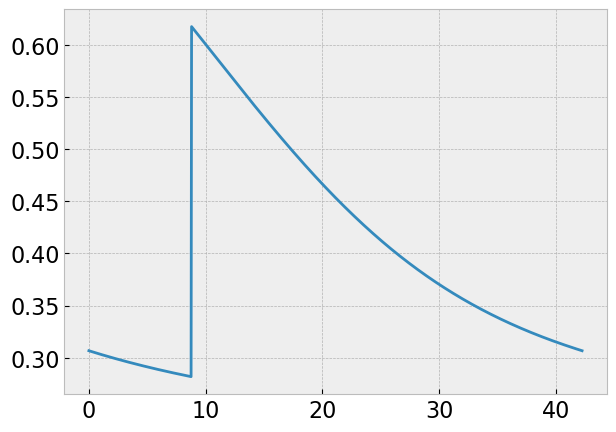

In [6]:
#x_s = newton(lambda v: sol_v.sol(v)[0] - v_s, 0)
#x_to_plot = sol_v.t

# Jamiton actual
#x_jam = np.linspace(x_plus, x_minus, 500)
#v_jam = sol_v.sol(x_jam)[0]

def rho_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_rho(x_per)

def u_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_u(x_per)

L = np.abs(x_minus-x_plus)
x_to_plot = np.linspace(0, L, 1000)#np.linspace(0, L, 1000)
des = 55

plt.plot(x_to_plot, rho_per(x_to_plot)/rho_max)
plt.show()

# Simulation

In [7]:
# Jamiton creation
tau = 5
rho_s = 0.433 * rho_max#0.6 * rho_max #0.43334728629845265 * rho_max #0.385 * rho_max # 0.3
v_s = 1/rho_s # Se necesita rho_s normalizado

m_bar = -h_bar_prime(v_s)
s_bar = U_bar(v_s) - m_bar * v_s

v_M  = newton_1D(50, lambda v: w_v(v, m_bar, s_bar), lambda v: w_v_prime(v, m_bar, s_bar))
r_min = r(v_s, m_bar)
r_max = r(v_M, m_bar)

v_R = root(lambda v: r(v, m_bar) - r_max, 10).x[0]

# Jamiton actual
v_minus = (v_M + v_s)/2
r_minus = r(v_minus, m_bar)
v_plus = newton_1D(8, lambda v: r(v, m_bar) - r_minus, lambda v: r_prime(v, m_bar))
r_plus = r(v_plus, m_bar)

# Resuelve EDO
t_f = 100
sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, 1_000_000), args=[tau, m_bar, s_bar], dense_output=True)
sol_v_eta = solve_ivp(ode_jam_v_eta, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, N_ODE), args=[m_bar, s_bar], dense_output=True)

sol_rho = lambda x: 1/sol_v.sol(x)[0]
sol_u = lambda x: rho_to_u(sol_rho(x), m_bar, s_bar)
sol_rho_eta = lambda x: 1/sol_v_eta.sol(x)[0]
sol_u_eta = lambda x: rho_to_u(sol_rho_eta(x), m_bar, s_bar)

# Encuentra xs
x_minus = newton(lambda v: sol_v.sol(v)[0] - v_minus, v_s)
x_plus = newton(lambda v: sol_v.sol(v)[0] - v_plus, 0)

In [8]:
v_minus

26.61542504578007

In [9]:
## get s_max
rho_s_zero = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max).x[0]
v_s_zero = 1/rho_s_zero
m_max = -h_bar_prime(v_s_zero)
s_max = U_bar(v_s_zero) - m_max * v_s_zero

In [10]:
def flux_rho(rho, y):
    return y-rho*h(rho)

def flux_y(rho, y):
    return (y**2)/rho - h(rho)*y

# Flujo con HLL
def F_HLL_rho(rho, y, l):

    rho_left =  np.roll(rho, 1)
    y_left = np.roll(y, 1)

    rho_right = np.roll(rho, -1)
    y_right = np.roll(y, -1)

    F_rho = flux_HLL_rho(rho, y, rho_right, y_right) - flux_HLL_rho(rho_left, y_left, rho, y)

    return F_rho

def F_HLL_y(rho, y, l):

    rho_left =  np.roll(rho, 1)
    y_left = np.roll(y, 1)

    rho_right = np.roll(rho, -1)
    y_right = np.roll(y, -1)

    F_y = flux_HLL_y(rho, y, rho_right, y_right) - flux_HLL_y(rho_left, y_left, rho, y)

    return F_y


# Solver HLL para riemann
def flux_HLL_rho(rho_l, y_l, rho_r, y_r):

    # Obtiene velocidades
    u_l = u_y(rho_l, y_l)
    u_r = u_y(rho_r, y_r)

    l_1_l = u_r - rho_r * h_prime(rho_r)
    l_1_r = u_l - rho_l * h_prime(rho_l)
    l_2_l = u_l
    l_2_r = u_r

    s_l = np.min([l_1_l, l_1_r])
    s_r = np.max([l_2_l, l_2_r])

    s_R_plus = np.max([s_r, 0])
    s_l_minus = np.min([s_l, 0])

    F_l = flux_rho(rho_l, y_l)
    F_r = flux_rho(rho_r, y_r)

    F_hat = (s_R_plus * F_l - s_l_minus * F_r + s_l_minus * s_R_plus * (rho_r - rho_l))/(s_R_plus - s_l_minus)
    return F_hat

def flux_HLL_y(rho_l, y_l, rho_r, y_r):

    # Obtiene velocidades
    u_l = u_y(rho_l, y_l)
    u_r = u_y(rho_r, y_r)

    l_1_l = u_r - rho_r * h_prime(rho_r)
    l_1_r = u_l - rho_l * h_prime(rho_l)
    l_2_l = u_l
    l_2_r = u_r

    s_l = np.min([l_1_l, l_1_r])
    s_r = np.max([l_2_l, l_2_r])

    s_R_plus = np.max([s_r, 0])
    s_l_minus = np.min([s_l, 0])

    F_l = flux_y(rho_l, y_l)
    F_r = flux_y(rho_r, y_r)

    F_hat = (s_R_plus * F_l - s_l_minus * F_r + s_l_minus * s_R_plus * (y_r - y_l))/(s_R_plus - s_l_minus)
    return F_hat

In [11]:
def ARZ_simulation(Q_0, x, tau, T, Nt, F_rho, F_y, as_array=True):

    t = np.linspace(0, T, Nt)
    dt = t[1] - t[0]

    # salto espacial
    dx = x[1] - x[0]
    N = len(x)

    CFL = 2 * s_max * dt/dx < 1

    if not CFL:
        print("CFL is not satisfied")
        pass

    # Guarda soluciones
    # Condición inicial

    if as_array:
        rho = np.zeros((Nt, N))
        y = np.zeros((Nt, N))

        rho[0] = Q_0[0]
        y[0] = Q_0[1]

    else:
        rho = Q_0[0]
        y = Q_0[1]

    for n in range(Nt-1):
        print("Step ", n, " of ", Nt)
        l = dt/dx

        if as_array:
            rho_n = rho[n]
            y_n = y[n]

        else:
            rho_n = rho
            y_n = y
        
        # Paso de Godunov
        rho_sig = rho_n - l * F_rho(rho_n, y_n, l)
        y_sig = y_n - l * F_y(rho_n, y_n, l)
        
        # Resuelve termino de relajación
        alpha = dt/tau

        # Implícito
        y_sig_ = (alpha/(1+alpha)) * rho_sig * (U(rho_sig) + h(rho_sig)) + (1/(1+alpha)) * y_sig
        y_sig = y_sig_

        # Guarda paso
        if as_array:
            rho[n+1] = rho_sig
            y[n+1] = y_sig

        else:
            rho = rho_sig
            y = y_sig

    return t, rho, y

In [12]:
def rho_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_rho(x_per)

def u_per(x):
    interval = x_minus - x_plus
    x_per = (x - x_plus) % interval + x_plus
    return sol_u(x_per)

def teo_rho_eta(x, t, s=s_bar):
    eta_minus = x_minus / tau
    eta_plus = x_plus / tau
    eta = (x - s*t)/tau
    interval = eta_minus - eta_plus
    eta_per = (eta - eta_plus) % interval + eta_plus

    return sol_rho_eta(eta_per)

def teo_u_eta(x, t, s=s_bar):
    eta_minus = x_minus / tau
    eta_plus = x_plus / tau
    eta = (x - s*t)/tau
    interval = eta_minus - eta_plus
    eta_per = (eta - eta_plus) % interval + eta_plus

    return sol_u_eta(eta_per)

In [33]:
T = 2
#Nt = 50_000
#N = 5_000 #500_000
L = np.abs(x_minus-x_plus)
dx = 2**(-4)/10 #L/(N-1)
N = int(L/dx) + 1
x = np.linspace(0, L, N)#np.linspace(0, L, 1000)

dt = dx/(2.1*s_max) # CFL
Nt = int(T/dt + 1)

rho_0 = rho_per(x) #rho_per(x)
u_0 = u_per(x) #u_per(x)
y_0 = rho_0 * (u_0 + h(rho_0))
Q_0 = [rho_0, y_0] #[np.zeros(N), np.zeros(N)]
t, rho, y = ARZ_simulation(Q_0, x, tau, T, Nt, F_HLL_rho, F_HLL_y, as_array=False)
u = y/rho - h(rho)

Step  0  of  10718
Step  1  of  10718
Step  2  of  10718
Step  3  of  10718
Step  4  of  10718
Step  5  of  10718
Step  6  of  10718
Step  7  of  10718
Step  8  of  10718
Step  9  of  10718
Step  10  of  10718
Step  11  of  10718
Step  12  of  10718
Step  13  of  10718
Step  14  of  10718
Step  15  of  10718
Step  16  of  10718
Step  17  of  10718
Step  18  of  10718
Step  19  of  10718
Step  20  of  10718
Step  21  of  10718
Step  22  of  10718
Step  23  of  10718
Step  24  of  10718
Step  25  of  10718
Step  26  of  10718
Step  27  of  10718
Step  28  of  10718
Step  29  of  10718
Step  30  of  10718
Step  31  of  10718
Step  32  of  10718
Step  33  of  10718
Step  34  of  10718
Step  35  of  10718
Step  36  of  10718
Step  37  of  10718
Step  38  of  10718
Step  39  of  10718
Step  40  of  10718
Step  41  of  10718
Step  42  of  10718
Step  43  of  10718
Step  44  of  10718
Step  45  of  10718
Step  46  of  10718
Step  47  of  10718
Step  48  of  10718
Step  49  of  10718
Step  50  

KeyboardInterrupt: 

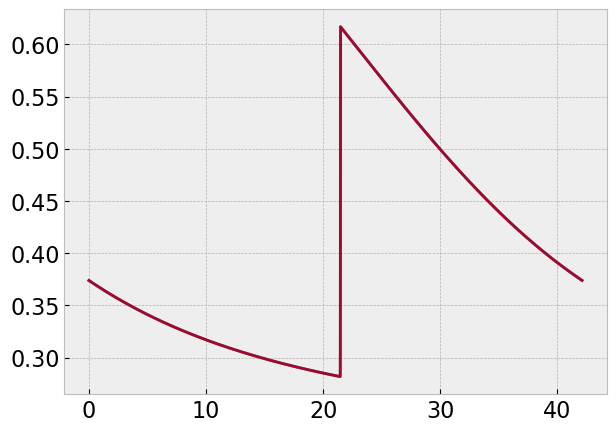

In [45]:
plt.plot(x, teo_rho_eta(x, T)/rho_max)
plt.plot(x, rho/rho_max)

In [138]:
# Notas
# Usar Nt = 10^6 para todos los errores
# Maximo N = 500_000
# El Nt cumple CFL para todo N menor a 500_000
# Esto aplica para un rho_s (0.433...). 
# Para otros jamitones, se pueden usar muchos mas puntos porque el largo del jamiton cambia
# Una ideales en vez de variar N, variar dx. Así me quito de encima la "dependencia" en L

In [23]:
j = 0
100 * norm(teo_rho_eta(x, T+j*dt) - rho, 1)/norm(teo_rho_eta(x, T+j*dt), 1)

nan

In [433]:
j = 0
100*norm(rho_per(x-s_bar*(T+j*dt)) - rho, 1)/norm(rho_per(x-s_bar*(T+j*dt)), 1)

0.06071150613877002

In [374]:
dxs = [(2)**(-j)/10 for j in range(3, 11)]
dxs[-1]

9.765625e-05

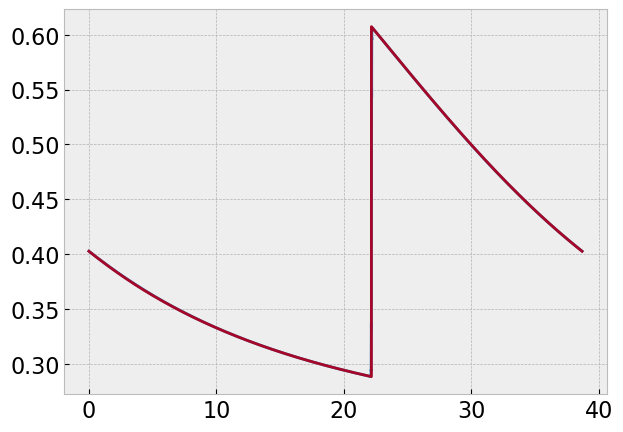

In [445]:
plt.plot(x, rho/rho_max)
plt.plot(x, teo_rho_eta(x, T)/rho_max)

In [ ]:
plt.plot(x, rho[10]/rho_max)
plt.plot(x, rho[1000]/rho_max)
plt.plot(x, rho[Nt//2]/rho_max)
plt.plot(x, rho[-1]/rho_max)

plt.plot(x, rho_per(x-s_bar*T)/rho_max)

In [ ]:
norm(rho_per(x-s_bar*T) - rho[-1], 1)/norm(rho_per(x-s_bar*T), 1)